# Global stress objective example

## Commented Program

What follows is a program spliced with comments.

In [1]:
using TopOpt, LinearAlgebra

### Define the problem

In [2]:
E = 1.0 # Young’s modulus
v = 0.3 # Poisson’s ratio
f = 1.0 # downward force
rmin = 3.0 # filter radius

problems = Any[
    PointLoadCantilever(Val{:Linear}, (60, 20), (1.0, 1.0), E, v, f),
    HalfMBB(Val{:Linear}, (60, 20), (1.0, 1.0), E, v, f),
]
problem_names = ["Cantilever beam", "Half MBB beam", "L-beam", "Tie-beam"]

i = 1
println(problem_names[i])
problem = problems[i]

Cantilever beam


### Parameter settings

In [3]:
V = 0.5 # volume fraction
xmin = 0.001 # minimum density
steps = 40 # maximum number of penalty steps, delta_p0 = 0.1
convcriteria = Nonconvex.KKTCriteria()
penalty = TopOpt.PowerPenalty(1.0)

PowerPenalty{Float64}(1.0)

### Define a finite element solver

In [4]:
solver = FEASolver(Direct, problem; xmin=xmin, penalty=penalty)

### Define **stress** objective
Notice that gradient is derived automatically by automatic differentiation (Zygote.jl)!

In [5]:
stress = TopOpt.von_mises_stress_function(solver)
filter = if problem isa TopOptProblems.TieBeam
    identity
else
    DensityFilter(solver; rmin=rmin)
end
volfrac = TopOpt.Volume(solver)

x0 = ones(length(solver.vars))
threshold = 3 * maximum(stress(filter(PseudoDensities(x0))))

obj = x -> volfrac(filter(PseudoDensities(x)))
constr = x -> norm(stress(filter(PseudoDensities(x))), 5) - threshold

#3 (generic function with 1 method)

### Define subproblem optimizer

In [6]:
N = length(solver.vars)
x0 = fill(0.5, N)

options = MMAOptions(; maxiter=2000, tol=Nonconvex.Tolerance(; kkt=1e-4), convcriteria)
model = Model(obj)
addvar!(model, zeros(N), ones(N))
add_ineq_constraint!(model, constr)
alg = MMA87()
r = optimize(model, alg, x0; options)

@show obj(r.minimizer)
@show constr(r.minimizer)

[ Info:   iter       obj      Δobj  violation  kkt_residual  
[ Info:      0   5.0e-01       Inf   7.4e-01   7.4e-01
[ Info:      1   3.3e-01   1.7e-01   3.3e+00   5.7e-01
[ Info:      2   6.9e-02   2.6e-01   7.3e+02   4.3e+01
[ Info:      3   4.3e-05   6.9e-02   1.8e+03   8.7e-04
[ Info:      4   6.7e-05   2.3e-05   1.7e+03   7.3e-04
[ Info:      5   7.5e-05   8.3e-06   1.7e+03   9.8e-04
[ Info:      6   3.5e-05   4.0e-05   1.7e+03   7.3e-04
[ Info:      7   8.1e-05   4.6e-05   1.7e+03   1.1e-03
[ Info:      8   3.7e-05   4.4e-05   1.7e+03   7.3e-04
[ Info:      9   8.5e-05   4.8e-05   1.7e+03   1.3e-03
[ Info:     10   4.2e-05   4.3e-05   1.7e+03   9.0e-04
[ Info:     11   9.1e-05   4.9e-05   1.7e+03   1.4e-03
[ Info:     12   4.5e-05   4.6e-05   1.7e+03   9.0e-04
[ Info:     13   9.6e-05   5.1e-05   1.7e+03   1.4e-03
[ Info:     14   5.0e-05   4.6e-05   1.7e+03   9.1e-04
[ Info:     15   9.4e-05   4.4e-05   1.7e+03   1.2e-03
[ Info:     16   5.4e-05   4.0e-05   1.7e+03   9.3e-04
[ I

1654.3571582678276

### (Optional) Visualize the result using Makie.jl
Need to run `using Pkg; Pkg.add("Makie")` first and either `Pkg.add("CairoMakie")` or `Pkg.add("GLMakie")`

In [7]:
using Makie
using CairoMakie

alternatively, `using GLMakie`

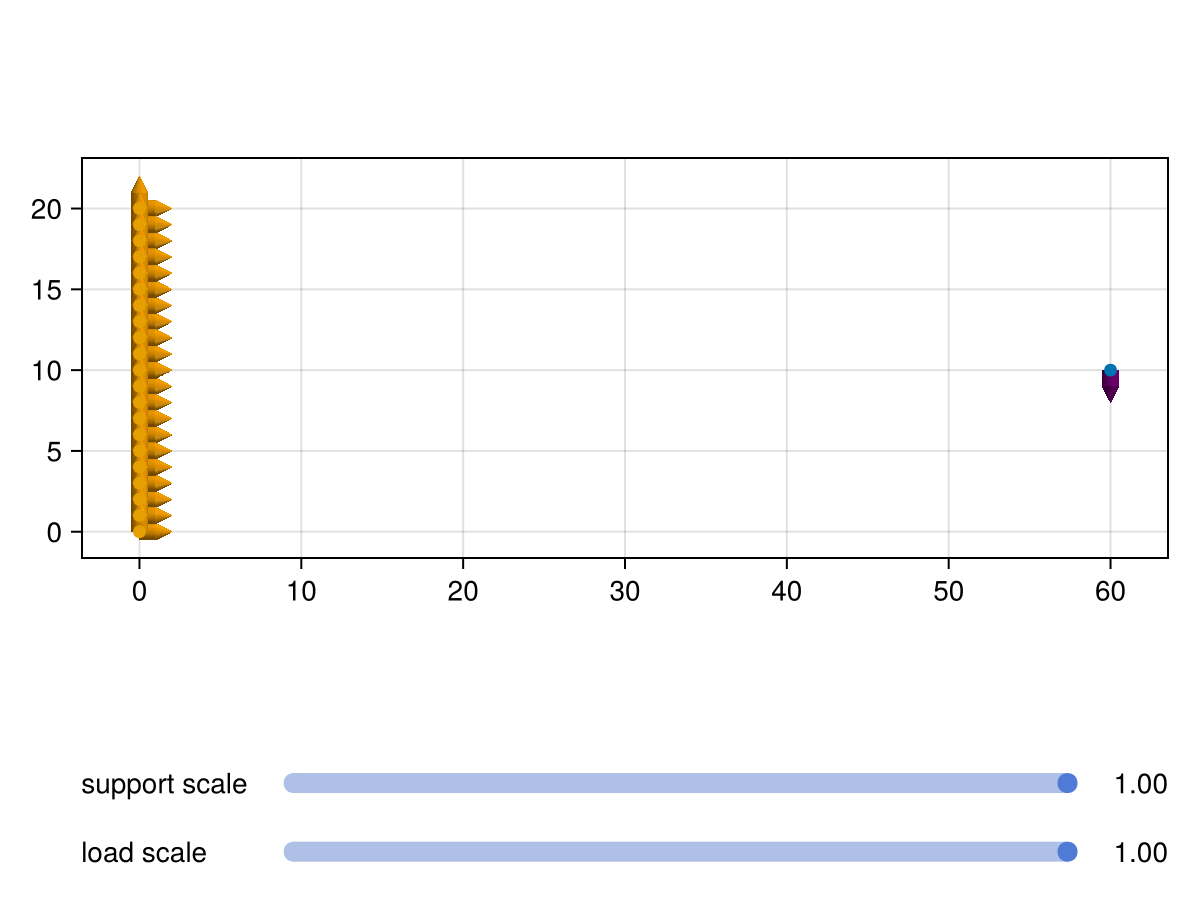

CairoMakie.Screen{IMAGE}


In [8]:
fig = visualize(problem; topology=r.minimizer)
Makie.display(fig)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*